# <span style="color:red">**Cancer de piel**</span> 

![fig_python](https://cdn2.salud180.com/sites/default/files/styles/medium/public/field/image/2019/08/diferencias-entre-carcinoma-y-melanoma-saberlo-puede-salvarte-la-vida-salud180.jpg)
Image Source: www.salud108.com

# Según el INC entre 1996 - 2010, 11 mil personas fueron diagnosticadas con un tipo de cáncer en la piel.

Es proposito de nuestro trabajo es casiflicar los tipos de cancer usando el dataset HAM10000 que contiene 10015 imágenes tomograficas de secciones de la piel afectadas por cancer

In [ ]:
#@title 1. MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
#print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········


TIMEOUT: ignored

## 1.1 Visualización de los datos

## 1.2 Arquitectura

### 1.2.2 Segmentación de imágenes

Arxiv Link: U-Net: Convolutional Networks for Biomedical Image Segmentation


*   UNet es una fully convolutional network(FCN) la cual se encarga de hacer segmentación de imagenes. Su proposito es predecir la clase de cada pixel.
*   UNet esta construida sobre FCN y modificada para producir una mejor segmentación en las imágenes médicas



##1.3 Dataset

Link: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

## 1.4 Code



### 1.4.2 Tarea de segmentación

In [ ]:
#@title Importación de libreríías { display-mode: "form" }
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Ruta del directorio del dataset
DatasetDir = os.path.join(os.getcwd(), "drive", "My Drive", "Proyecto_IA", "HAM10000_Data")
df = pd.read_csv(os.path.join(DatasetDir,'HAM10000_metadata.csv'))

In [ ]:
def get_paths_labels(DatasetDir):
  train_metadata ='HAM10000_metadata.csv'
  test_metadata = "ISIC2018_Task3_Test_NatureMedicine_AI_Interaction_Benefit.csv"

  train = os.path.join(DatasetDir, train_metadata) 

  df = pd.read_csv(train)

  lb_style = LabelBinarizer()
  lb_results = lb_style.fit_transform(df.dx_type)
  target = pd.DataFrame(  lb_results, columns=lb_style.classes_)
  target["image_id"] = df["image_id"]

  images_path = os.path.join(DatasetDir,"HAM10000_images")
  images_pathS = os.path.join(DatasetDir,"HAM10000_segmentations")

  paths =  [images_path + "/" + id for id in target["image_id"]]
  target = [images_pathS + "/" + id for id in target["image_id"]]

  return (pd.Series(paths), pd.Series(target))
  

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=100, dim=(128,128), n_channels=3,
                 n_classes=4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def read_image(self,path, tam=128):
      return cv2.resize(cv2.imread(path+".jpg"), (tam,tam))*1./255
      
    def get_target(self,labels, tam=128):
      return cv2.resize(cv2.imread(os.path.join(DatasetDir,"HAM10000_segmentations",labels+"_segmentation.png")), (tam,tam))[:,:,0]*1./255
      #return self.labels[self.labels.image_id==path.split("/")[-1]].iloc[0,:-1]

    def __getitem__(self, index):
        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim))
#        y = np.empty((self.batch_size,self.n_classes))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.read_image(ID)
            # Store class
            y[i,] = self.get_target(ID.split("/")[-1])

        return X, y

    def one_data(self, ID):
      return  self.read_image(ID), self.get_target(ID)


In [ ]:
BATCH_SIZE = 32
X,Y = get_paths_labels(DatasetDir)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

training_generator = DataGenerator(X_train, Y_train, batch_size=BATCH_SIZE)
testing_generator = DataGenerator(X_test, Y_test, batch_size=BATCH_SIZE)

##Filtros segmentación

In [ ]:
from sklearn.metrics import mean_squared_error
sim = np.ones((10015,1))
for i in range(len(X)):
  img = cv2.imread(X[i]+".jpg")
  grayscale = 255 - cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  groundtruth = cv2.imread(Y[i]+"_segmentation.png")[:,:,1]
  median_filtered = scipy.ndimage.median_filter(grayscale, size=3)
  threshold = skimage.filters.threshold_otsu(median_filtered)
  predicted = np.uint8(median_filtered > threshold) 
  sim[i] = mean_squared_error(groundtruth, predicted, squared=True)
np.save('/content/drive/My Drive/Proyecto_IA/copias/vector_error2', sim)

In [ ]:
sim =np.load('/content/drive/My Drive/Proyecto_IA/copias/vector_error2.npy')
print(np.median(sim))

0.8512887833118633


Devoirs



*   Histogramas del error, opcional(clases)
*   Comparación de metodos de segmentación 
*   Guardar U-net 
*   Arreglar flitros






In [ ]:
print(float(sim.mean()))

0.33719818970784043


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


(-0.5, 599.5, 449.5, -0.5)

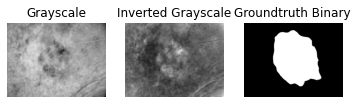

In [ ]:
#@title  MOSTRAR DATOS { display-mode: "form" }
i = 2
#grayscale = 255 - cv2.imread(X[i]+".jpg")[:,:,1]
img = cv2.imread(X[i]+".jpg")
grayscale = 255 - cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
groundtruth = cv2.imread(Y_train[i]+"_segmentation.png")
plt.subplot(1, 3, 1)
plt.imshow(255 - grayscale, cmap='gray')
plt.title('Grayscale')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(grayscale, cmap='gray')
plt.title('Inverted Grayscale')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(groundtruth)
plt.title('Groundtruth Binary')
plt.axis('off')

Text(0.5, 1.0, 'Median filtered image')

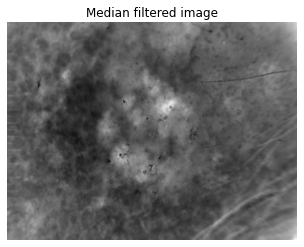

In [ ]:
#@title MEDIA DE LA IMAGEN { display-mode: "form" }
median_filtered = scipy.ndimage.median_filter(grayscale, size=3)
plt.imshow(median_filtered, cmap='gray')
plt.axis('off')
plt.title('Median filtered image')

Threshold value is 80


Text(0.5, 1.0, 'otsu predicted binary image')

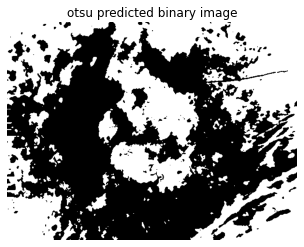

In [ ]:
#@title PREDICCIÓN { display-mode: "form" }
threshold = skimage.filters.threshold_otsu(median_filtered)
print('Threshold value is {}'.format(threshold))
predicted = np.uint8(median_filtered > threshold) * 255
plt.imshow(predicted, cmap='gray')
plt.axis('off')
plt.title('otsu predicted binary image')

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report
def matriz_confusion(ytest, ypredict):
    conf_matrix = confusion_matrix(ytest, ypredict)
    plt.figure(figsize=(7, 4))
    sns.heatmap(conf_matrix, xticklabels=lb_style.classes_, yticklabels=lb_style.classes_, annot=True, fmt="d");
    plt.title("Matriz de confusión")
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase predicha')
    plt.show()
    print (classification_report(ytest, ypredict))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def get_accuracy(groundtruth_list, predicted_list):

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    
    return accuracy

Random Forest


TypeError: ignored

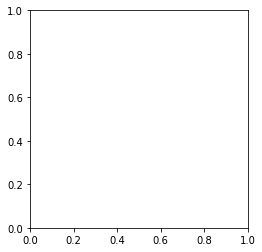

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('/content/drive/My Drive/Proyecto_IA/HAM10000_Data/HAM10000_segmentations/ISCI_0034320_segmentation.png')

df = pd.DataFrame()
plt.show()

In [ ]:
#ADD ORIGINAL PIXELS VALUES TO DATA FRAME
im2 = img.reshape(-1)
df['Original image'] =  img2

#GABOR FEATURES
num = 1
kernels = []
for tetha in range(2):
  theta = tetha / 4. * np.pi
  for sigma in (1,3):
    for lamda in np.arange(0, np.pi, np.pi / 4):
      for gamma in (0.05, 0.5):

        gabor_label = 'Gabor' + str(num)

        ksize = 5
        kernel = cv2.getGaborKernel((ksize,ksize), sigma, theta, lamda, gamma, 0, ktype = cv2.CV_32F)
        kernels.append(kernel)

        fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
        filtered_img = fimg.reshape(-1)
        df[gabor_label] = filtered_img
        num += 1


## U-net

In [ ]:
#@title U-net { display-mode: "form" }

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


def UNet():
    f = [16, 32, 64, 128, 256]
    image_size = 128
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
#
log_folder = "/"
for folder in DatasetDir.split("/")[:-1]:
  log_folder = os.path.join(log_folder, folder)


tensorboard_dir = os.path.join("logs","fit_tensorboard_clas_seg",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_path =  os.path.join(log_folder,"checkpoints_model_clas_seg", "cpS.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=1)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)

In [ ]:
os.path.exists(log_folder)

True

In [ ]:
BATCH_SIZE = 32

# Asegurarse de tener seleccionada la GPU como acelerador de hardware
with tf.device("/gpu:0"):
  model = UNet()
  model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



  training_generator = DataGenerator(X_train, Y_train, batch_size=BATCH_SIZE)
  testing_generator = DataGenerator(X_test, Y_test, batch_size=BATCH_SIZE)

  model.fit(training_generator , epochs=35,batch_size=BATCH_SIZE , validation_data=testing_generator , callbacks=[tensorboard_callback, cp_callback])

error: ignored

In [ ]:
# Evaluate the restored model
loss, acc = new_model.evaluate(testing_generator, batch_size = BATCH_SIZE, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

print(new_model.predict(test_images).shape)

In [ ]:
#@title Evaluación { display-mode: "form" }
model.evalute(testing_generator, batch_size = BATCH_SIZE)